In [51]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import corner

import retrieval_base.auxiliary_functions as af

def plot_hist1d(ax, posterior, ec, fc, xrange, bins=25, ls='-', ymarker=0.05, sigma_to_plot=1, label=None):

    q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

    _, _, p = ax.hist(
        posterior, bins=bins, range=xrange, histtype='step', fill=True, 
        ec=ec, fc=fc, ls=ls, label=label, 
        )

    idx = [2,-3]
    if sigma_to_plot == 2:
        idx = [1,-2]
    elif sigma_to_plot == 3:
        idx = [0,-1]

    median = np.median(posterior)
    xerr = np.abs(np.quantile(posterior, q=q[idx])-median)[:,None]
    ax.errorbar(
        median, ymarker, xerr=xerr, 
        fmt='o', c=ec, capthick=2, elinewidth=2, markersize=4, 
        transform=ax.get_xaxis_transform(), #zorder=10
        )

    xerr = np.abs(np.quantile(posterior, q=q[idx])-median)[:,None]
    print('{:} | -{:} +{:}'.format(median, *xerr.flatten()))

    return p[0], median, xerr

In [5]:
res = af.read_results('./retrieval_outputs/order_6_A_ret_1/test_', n_params=27)
posterior_A, bestfit_A, PT_A, Chem_A, int_contr_em_A, int_contr_em_per_order_A, int_opa_cloud_A, m_spec_A, d_spec_A, LogLike_A, Cov_A, bestfit_params_A = res
del res

res = af.read_results('./retrieval_outputs/order_6_B_ret_1/test_', n_params=27)
posterior_B, bestfit_B, PT_B, Chem_B, int_contr_em_B, int_contr_em_per_order_B, int_opa_cloud_B, m_spec_B, d_spec_B, LogLike_B, Cov_B, bestfit_params_B = res
del res

  analysing data from ./retrieval_outputs/order_6_A_ret_1/test_.txt
  analysing data from ./retrieval_outputs/order_6_B_ret_1/test_.txt


In [53]:
def get_colors(color):

    envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        name='envelope_cmap', colors=[color, color], 
        )
    envelope_colors = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
    envelope_colors[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

    return envelope_colors, color

env_color_A, color_A = get_colors('purple')
env_color_B, color_B = get_colors('darkorange')

74.34446569037735 | -4.73031347247904 +5.093331215070364
64.20177460478585 | -4.350691086601756 +4.709641175631148
0.681632257904658 | -0.005884293549883957 +0.006442240893253848
0.6778258754594944 | -0.005783620762469854 +0.004952782770808795
-0.10469188844255939 | -0.049226673194344706 +0.05741148539620886
-0.3319423820174052 | -0.02609132626513022 +0.030389531482432952
21562.736576252337 | -19302.946264326245 +303331.78577909124
782.5516197685599 | -295.61310246744927 +1169.7295162409569


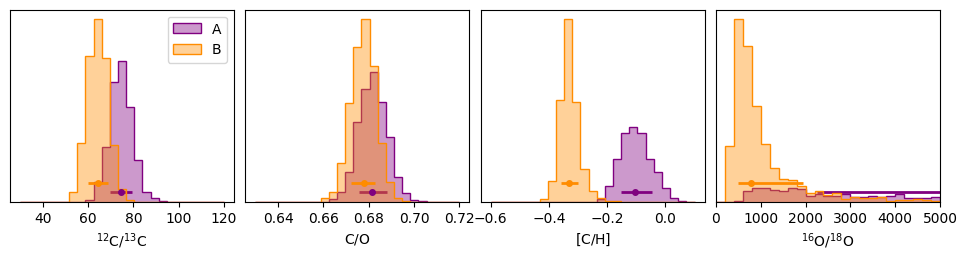

In [54]:
Chem_A.C_ratio_posterior = 10**posterior_A[:,10] / 10**posterior_A[:,14]
Chem_B.C_ratio_posterior = 10**posterior_B[:,10] / 10**posterior_B[:,14]

Chem_A.O_ratio_posterior = 10**posterior_A[:,10] / 10**posterior_A[:,15]
Chem_B.O_ratio_posterior = 10**posterior_B[:,10] / 10**posterior_B[:,15]

fig, ax = plt.subplots(
    figsize=(12,2.5), ncols=4, gridspec_kw={'wspace':0.05}
    )

plot_hist1d(
    ax[0], Chem_A.C_ratio_posterior, ec=color_A, fc=env_color_A[2], xrange=(30,120), label='A'
    )
plot_hist1d(
    ax[0], Chem_B.C_ratio_posterior, ec=color_B, fc=env_color_B[2], xrange=(30,120), ymarker=0.1, label='B'
    )

plot_hist1d(
    ax[1], Chem_A.CO_posterior, ec=color_A, fc=env_color_A[2], xrange=(0.63,0.72)
    )
plot_hist1d(
    ax[1], Chem_B.CO_posterior, ec=color_B, fc=env_color_B[2], xrange=(0.63,0.72), ymarker=0.1
    )

plot_hist1d(
    ax[2], Chem_A.FeH_posterior, ec=color_A, fc=env_color_A[2], xrange=(-0.6,0.1)
    )
plot_hist1d(
    ax[2], Chem_B.FeH_posterior, ec=color_B, fc=env_color_B[2], xrange=(-0.6,0.1), ymarker=0.1
    )

plot_hist1d(
    ax[3], Chem_A.O_ratio_posterior, ec=color_A, fc=env_color_A[2], xrange=(0,5000)
    )
plot_hist1d(
    ax[3], Chem_B.O_ratio_posterior, ec=color_B, fc=env_color_B[2], xrange=(0,5000), ymarker=0.1
    )

ax[0].legend(loc='upper right')

ax[0].set(yticks=[], xlabel=r'$\mathrm{^{12}C/^{13}C}$')
ax[1].set(yticks=[], xlabel=r'$\mathrm{C/O}$')
ax[2].set(yticks=[], xlabel=r'$\mathrm{[C/H]}$')
ax[3].set(yticks=[], xlabel=r'$\mathrm{^{16}O/^{18}O}$', xlim=(0,5000))

#Chem_wo_GPs.C_ratio_posterior = 10**posterior_wo_GPs[:,10] / 10**posterior_wo_GPs[:,12]
#posterior_1[]
plt.show()

0.9331931302225103 | -0.015539842500050582 +0.014332771965664626
0.9463164007239511 | -0.01567806409376382 +0.014331723293078746
4.692151392698281 | -0.0658932476775469 +0.07082136503029268
4.486550536367091 | -0.044141014205020035 +0.048611594177918604
17.1589964333509 | -0.028048240829495086 +0.02797940200074933
19.61661050015245 | -0.05353687525944295 +0.054489887270150916
14.750580043096777 | -0.09947014974580348 +0.10822956142857088
26.332242886642913 | -0.09752470093817678 +0.10058826871503967
0.5698243176283793 | -0.0402645868944278 +0.042592151757831265
0.9889143119963226 | -0.010243092172800505 +0.007436820049518067


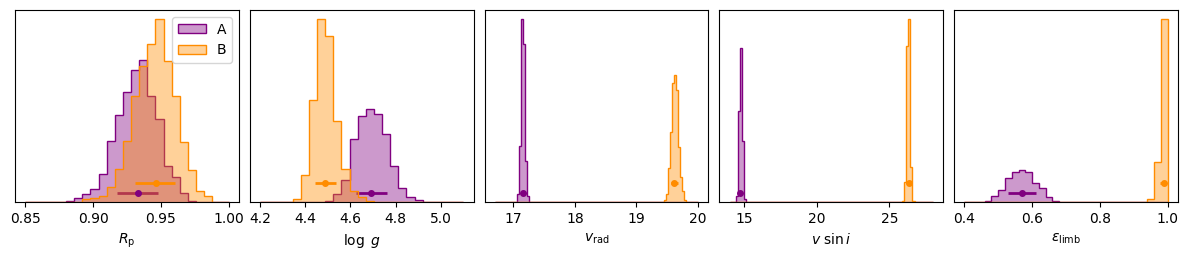

In [79]:
fig, ax = plt.subplots(
    figsize=(15,2.5), ncols=5, gridspec_kw={'wspace':0.05}
    )

plot_hist1d(
    ax[0], posterior_A[:,2], ec=color_A, fc=env_color_A[2], xrange=(0.85,1.), label='A'
    )
plot_hist1d(
    ax[0], posterior_B[:,2], ec=color_B, fc=env_color_B[2], xrange=(0.85,1.), ymarker=0.1, label='B'
    )

plot_hist1d(
    ax[1], posterior_A[:,3], ec=color_A, fc=env_color_A[2], xrange=(4.2,5.1)
    )
plot_hist1d(
    ax[1], posterior_B[:,3], ec=color_B, fc=env_color_B[2], xrange=(4.2,5.1), ymarker=0.1
    )

plot_hist1d(
    ax[2], posterior_A[:,6], ec=color_A, fc=env_color_A[2], xrange=(16.7,20), bins=100
    )
plot_hist1d(
    ax[2], posterior_B[:,6], ec=color_B, fc=env_color_B[2], xrange=(16.7,20), bins=100, ymarker=0.1
    )

plot_hist1d(
    ax[3], posterior_A[:,5], ec=color_A, fc=env_color_A[2], xrange=(14,28), bins=100
    )
plot_hist1d(
    ax[3], posterior_B[:,5], ec=color_B, fc=env_color_B[2], xrange=(14,28), bins=100, ymarker=0.1
    )

plot_hist1d(
    ax[4], posterior_A[:,4], ec=color_A, fc=env_color_A[2], xrange=(0.4,1), bins=30
    )
plot_hist1d(
    ax[4], posterior_B[:,4], ec=color_B, fc=env_color_B[2], xrange=(0.4,1), bins=30, ymarker=0.1
    )

ax[0].legend(loc='upper right')

ax[0].set(yticks=[], xlabel=r'$R_\mathrm{p}$')
ax[1].set(yticks=[], xlabel=r'$\log\ g$')
ax[2].set(yticks=[], xlabel=r'$v_\mathrm{rad}$')
ax[3].set(yticks=[], xlabel=r'$v\ \sin i$')
ax[4].set(yticks=[], xlabel=r'$\varepsilon_\mathrm{limb}$')

#Chem_wo_GPs.C_ratio_posterior = 10**posterior_wo_GPs[:,10] / 10**posterior_wo_GPs[:,12]
#posterior_1[]
plt.show()